Group names - Yarden Wolf (52671005), Gilad Shappir (47441654) and Asaf Gothelf (80823230)

# Final Project ECON 323

## Introduction and Research Question

Housing Prices Dataset - https://www.kaggle.com/datasets/yasserh/housing-prices-dataset?resource=download

(Dataset from Kaggle)

Our project focuses on housing prices. As ECON students, understanding the housing market and the different factors that affect housing prices is crucial to us, especially with all the housing reforms being made in our home country.

The dataset we chose is called "Housing Prices Dataset". It is a small, yet a challenging dataset, mainly due to the fact that it has strong multicollinearity, which arises it's complexity. The data set contains 13 housing features (such as number of parking spots, number of stories etc) and 549 observations of different houses being measured.

For this project, our main goal is to use Machine Learning algorithms to be able to predict housing prices based on the features existing in our data, and compare between them. We believe that if successful, our findings can benefit anyone who's trying to estimate housing prices both as a buyer and a seller.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

First of all, we'd like to see how different features distribute, how they correlate with each other and also find out more statistic information about them.

In [2]:
data_without_clean = pd.read_csv('Housing_prices_data.csv')
# We will work on the 'data' file in the project:
data = pd.read_csv('Housing_prices_data.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000.0,7420,4.0,2.0,3,yes,no,no,no,yes,2,yes,furnished
1,12250000.0,8960,4.0,4.0,4,yes,no,no,no,yes,3,no,furnished
2,12250000.0,9960,3.0,2.0,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000.0,7500,4.0,2.0,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000.0,7420,4.0,1.0,2,yes,yes,yes,no,yes,2,no,furnished


The features in the data are:
- price: The price of the observed house
- area: The size of the house in
- bedrooms: Number of bedrooms in the house
- bathrooms: Number of bathrooms in the house
- stories: Number of stories in the house
- mainroad: If the house has access via main road
- guestroom: If the house has a guestroom
- basement: If the house has a basement
- hotwaterheating: If the house has hot water heating inside
- airconditioning: If the house has airconditioning inside
- parking: If the house has at least one parking spot
- prefarea: If the house located in prefarea 
- furnishingstatus: If the house is comes furnished 

Checking for missing values and outliers, and create a visualization for every feature that has missing values and that is continous in order to explore how to fill it's values and how to remove outliers.
We mainly want to explore features that we're going to change later on for our ML modules.

Function that returns the missing values per feature:

In [3]:
def missing_values (data):
    null_data = data.isnull().sum()
    null_data_above_0 = null_data[null_data>0]
    df_data = pd.DataFrame(null_data_above_0, columns=['COUNT'])
    return df_data

In [4]:
missing_values(data).sort_values('COUNT', ascending=False)

,COUNT
bathrooms,4
price,2
bedrooms,2


Based on these results, we know on which features we need to focus more in our data exploration.

Now we'll try to learn more about them:

(0.0, 450.0)

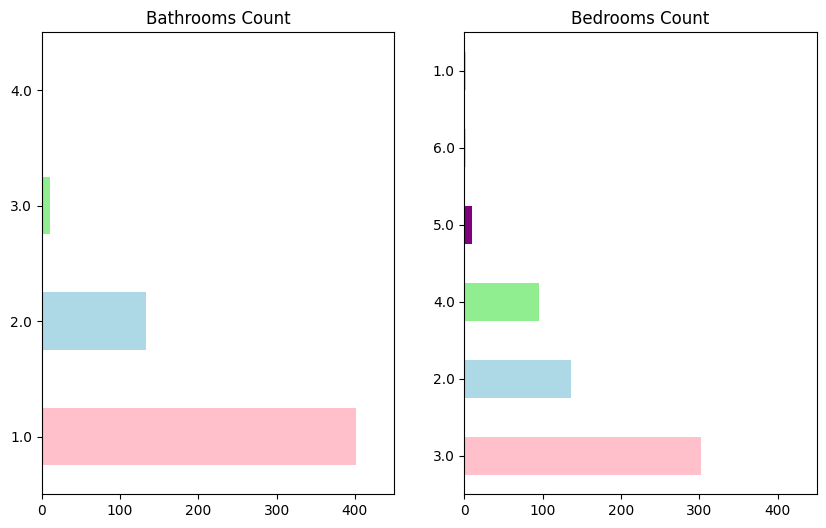

In [5]:
fig2, ax2 = plt.subplots(1, 2, figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen', 'purple']
data['bathrooms'].value_counts().plot(ax=ax2[0], kind = 'barh', color=colors)
data['bedrooms'].value_counts().plot(ax=ax2[1], kind = 'barh', color=colors)
ax2[0].set_title('Bathrooms Count')
ax2[1].set_title('Bedrooms Count')
ax2[0].set_xlim(0, 450)
ax2[1].set_xlim(0, 450)

Conclutions:
 - Based on how 'bathrooms' and 'bedrooms' features are distributed, we think the best way to deal with missing values is by replacing them with the Mode statistic in the Preprocessing part:

array([[<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'area'}>]], dtype=object)

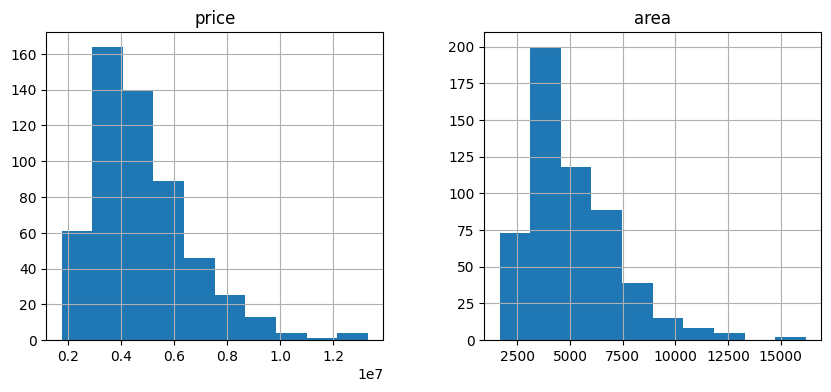

In [6]:
data.hist(column=['price', 'area'], figsize=(10,4))

Based on the distribution of the 'price' feature, we will fill the missing values by the mean (In the next part we will convert the 'price' feature to be 'log(price)') and deal with outliers the same way, because it'll generate the same observations as outliers.

It is important to mention that in our opinion, this is the best way to fill those missing values because we are going to handle with outliers later on, and we don't want to drop too many observations when our dataset is already pretty small. 

We'll also deal with missing values for the 'area' feature in the same way as for 'price'.

We want to see how different categories of 'furnishingstatus' distribute over housing prices:

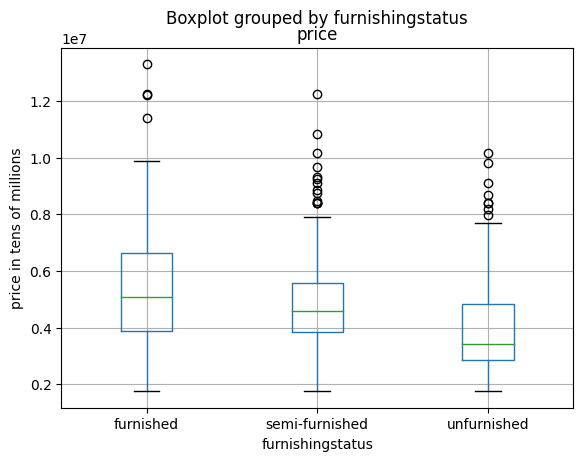

In [7]:
data.boxplot(column='price', by='furnishingstatus')
plt.ylabel('price in tens of millions')
plt.show()

Conclusions:
 - We can see that as the house is more furnished, so the price is increasing.
 - We can see the outliers based on the boxplot. In the next part (Data Preprocessing) we will get rid of them.

Checking the correlation between all of the numerical fearures:

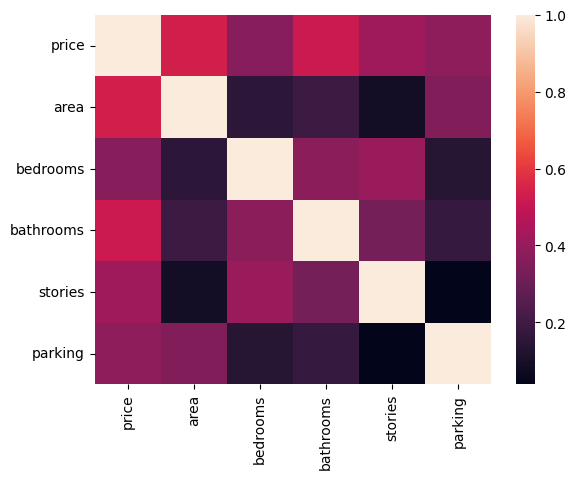

In [8]:
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns)
plt.show()

Conclusions:
 - For featurs with strong correlation with the prediction ('price') feature we will assume that they will be the most important features to affect and contribute our modeling in the upcoming parts. Particularly, the features 'area' and 'bathrooms', that we can see from the heatmup, contribute the most.

## Data Preprocessing

After that, we'll deep dive into the data and try to figure out how to deal with outliers, if the data is standardized, how to deal with missing data, how to compute categorial features into our models (dummy variables), addition of new features if needed and trying to reduce the dimensionality of the data to make our models less complex while explaining as much of the dataset's variation as possible.

We want to see the affect on the price by percentiles, so we'll work on the log of the price as our predicted value. 

In this part we'll also divide our dataset into train data and test data randomly. We're taking this course of action so we can see how well our supervised modules preform at making housing prices predictions. 


Changing the 'price' feature to be log of the price:

In [9]:
data['log_price'] = np.log(data['price'])
data.drop('price', axis=1, inplace=True)

Changing the cateforial (that have yes/no values) features to be a boolian type:

In [10]:
yes_no_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def yes_no_function(x):
    if x == "yes":
        out = 1
    elif x == "no":
        out = 0
    else:
        out = None
    return out

data[yes_no_features] = data[yes_no_features].applymap(yes_no_function)

Spliting the data into train and test data for our prediction:

In [11]:
test_data, train_data = train_test_split(data.copy(), test_size = 0.8, random_state= 42, shuffle=True)

Removing the prediction feature - log_price, from the test dataset, and save it as a new variable.
We do this in order to compare our results of the prediction log_price to the actual log_price of the test dataset at the end of the Modeling section. 

In [12]:
actual_test_log_price = pd.DataFrame(test_data["log_price"])
test_data.drop("log_price", axis=1, inplace=True)
train_data.shape

(440, 13)

The dataset that we chose randomly has 440 observations and 13 features. Therefore, because it's relatively big, this train dataset is indeed representative and reflects the population that we want to study.

### Dealing with outliers

In the previous part we noticed some outliers in some of the features by reviewing the histograms and boxplots .Now we will handle it by removing extreme values that can have an unproportional effect on our modules.

Our way of doing that will be by removing the top percentile, which we think will eliminate most of the unwanted values while not removing too many observations.

Drop outliers function:

In [13]:
def drop_outliers(data, feature):
    data.drop(data.loc[data[feature] > data[feature].quantile(0.99)].index, inplace=True)

'log_price' feature:

In [14]:
drop_outliers(train_data, 'log_price')

'area' feature:

In [15]:
drop_outliers(train_data, 'area')

### Dealing with missing values both in train and test data

Using the 'missing_values' function created earlier:

In [16]:
missing_values(train_data).sort_values('COUNT', ascending=False)

,COUNT
bathrooms,2
log_price,2
bedrooms,1


In [17]:
missing_values(test_data).sort_values('COUNT', ascending=False)

,COUNT
bathrooms,2
bedrooms,1


Filling missing values in 'bathrooms' feature:

In [18]:
train_data['bathrooms'] = train_data['bathrooms'].fillna(train_data['bathrooms'].mode()[0])
test_data['bathrooms'] = test_data['bathrooms'].fillna(test_data['bathrooms'].mode()[0])

Filling missing values in 'bedrooms' feature:

In [19]:
train_data['bedrooms'] = train_data['bedrooms'].fillna(train_data['bedrooms'].median())
test_data['bedrooms'] = test_data['bedrooms'].fillna(test_data['bedrooms'].median())

Filling missing values in 'log_price' feature:

In [20]:
train_data['log_price'] = train_data['log_price'].fillna(train_data['log_price'].mean())

It's important to mention that we want to avoide any outside impact on our test dataset!

That means that we'll fill missing values in the test dataset based on values found in it and not based on values we got from our train dataset. This course of action will help to eliminate some possibilities of overfitting in our modules.

### Dealing with Dummy variables

Here we defined a function that takes a categorial feature found in our dataset (train and test), and changes it into the appropriate number of dummy variables needed to represent it. 
In the end, the function returns the new datasets with the dummies and without the original qualitative feature.

In [21]:
def Get_Dummies(feature, predict_feature, train_data, test_data):
    train_data = pd.get_dummies(train_data, prefix=[feature], columns = [feature], drop_first=True)
    ordered_cols = [x for x in train_data.columns if x not in[predict_feature]] + [predict_feature]
    train_data = train_data[ordered_cols]
    test_data = pd.get_dummies(test_data, prefix=[feature], columns = [feature], drop_first=True)
    return train_data, test_data

After closer look at the data we can see a few categorial features that need to be convert into dummies. In that way, we will be able to see the affect every category has on the price of the house.

Convert the features 'furnishingstatus', 'bedrooms', 'bathrooms', 'stories' and 'parking' into dummy variables:

In [22]:
train_data, test_data = Get_Dummies('furnishingstatus', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('bedrooms', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('bathrooms', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('stories', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('parking', 'log_price', train_data, test_data)
train_data.shape, test_data.shape

((430, 23), (109, 21))

Wait...

How is that possible that after the same process on the same features, we got one more feature (except the prediction/label feature) in our train dataset than in the test dataset?

In [23]:
train_data_features, test_data_features = np.array(train_data.columns), np.array(test_data.columns)
print(f"Train data features: {train_data_features}\n\n Test data features: {test_data_features}")

Train data features: ['area' 'mainroad' 'guestroom' 'basement' 'hotwaterheating'
 'airconditioning' 'prefarea' 'furnishingstatus_semi-furnished'
 'furnishingstatus_unfurnished' 'bedrooms_2.0' 'bedrooms_3.0'
 'bedrooms_4.0' 'bedrooms_5.0' 'bedrooms_6.0' 'bathrooms_2.0'
 'bathrooms_3.0' 'stories_2' 'stories_3' 'stories_4' 'parking_1'
 'parking_2' 'parking_3' 'log_price']

 Test data features: ['area' 'mainroad' 'guestroom' 'basement' 'hotwaterheating'
 'airconditioning' 'prefarea' 'furnishingstatus_semi-furnished'
 'furnishingstatus_unfurnished' 'bedrooms_2.0' 'bedrooms_3.0'
 'bedrooms_4.0' 'bedrooms_5.0' 'bathrooms_2.0' 'bathrooms_4.0' 'stories_2'
 'stories_3' 'stories_4' 'parking_1' 'parking_2' 'parking_3']


A deep dive into our datasets reveal that there's another feature (bedrooms_6.0) that appears only in a few observation which exist only in the train dataset! It happened as a result of small repititions of this category, and the random split of the observations into train and test as we did earlier.

Due to it's rarity, we'll drop this observation (definatly an outlier) and that will solve this problem.

In [24]:
train_data = train_data.drop('bedrooms_6.0', axis=1)
train_data.shape, test_data.shape

((430, 22), (109, 21))

After these changes, let's see how our train and test datasets look like:

In [25]:
train_data.head(3)

,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,bedrooms_2.0,...,bedrooms_5.0,bathrooms_2.0,bathrooms_3.0,stories_2,stories_3,stories_4,parking_1,parking_2,parking_3,log_price
195,4410,1,0,1,0,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,15.418930
79,6000,1,1,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,15.710127
479,3000,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,14.901038


In [26]:
test_data.head(3)

,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,bedrooms_2.0,...,bedrooms_4.0,bedrooms_5.0,bathrooms_2.0,bathrooms_4.0,stories_2,stories_3,stories_4,parking_1,parking_2,parking_3
532,3970,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,8100,1,1,1,0,1,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
326,3460,1,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


Before dealing with dimentionality reduction and normalization, we will devide the dataset into x train, y train and x test:

In [27]:
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:].values

### Dealing with Normalization

In our data, some of the features are normalized and some aren't. Data normalization is the method of organizing data to appear similar across all records and fields. Performing so, always results in getting higher quality data and better results. This process basically includes eliminating unstructured data and duplicates in order to ensure logical data storage. 

Normalizing all features to be between 0 and 1 by reducing the minimal value and dividing by the max by 'MinMaxScaler()' method (according to the distributions found in the train dataset). Obviously, we won't normalize y_train (the label that represents the log_prices) because this is our predicted feture that we would like to predict at the end.

In [28]:
scaler = MinMaxScaler()
X_train_normalize = scaler.fit_transform(X_train)
X_test_normalize = scaler.fit_transform(X_test)

### Dimentionality Reduction Process - Forward Selection


Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

our "punishment" method in which we'll evaluate the number of features will be Mallow's C_p.
In statistics, Mallows's Cp is used to assess the fit of a regression model that has been estimated using ordinary least squares. It is applied in the context of model selection, where a number of predictor variables are available for predicting some outcome, and the goal is to find the best model involving a subset of these predictors. A small value of Cp means that the model is relatively precise.

Formulas:

$ C_p= MSE+2\frac{d+1}{n}\hat{\sigma}^2$ <br><br>
Where : $ \hat{\sigma}^2 = \frac{RSS_{all features}}{n-\#features-1} $,   and $\#features$ is the number of all features

We'll evaluate our Forward Feature Selection using Mallow's C_p

![https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg](https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg)

Feature Selection using Linear Regression:

In [29]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    reg  = LinearRegression()
    reg.fit(X, y)
    y_preds = reg.predict(X)
    MSE = mean_squared_error(y, y_preds)
    RSS = MSE * len(X)
    sigma_hat_squared = RSS / (len(X) - len(X[1]) - 1)
    return sigma_hat_squared

In [30]:
def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    reg  = LinearRegression() 
    reg.fit(X, y)
    preds = reg.predict(X)
    MSE = mean_squared_error(y, preds)
    d = X.shape[1]
    n = len(X)
    Cp = MSE + (2* sigma_hat_squared * (d + 1)) / n
    return Cp

In [31]:
def add_feature(X: np.array ,y: np.array ,current_features, sigma_hat_squared: float):
    best_score = np.inf
    num_of_features = X.shape[1]
    for i in range(num_of_features):
        if i in current_features:
            continue
        current_features_copy_added_feature = current_features.copy()
        current_features_copy_added_feature.append(i)
        current_features_copy_added_feature.sort()
        current_Cp = get_mallows_cp_score(X[:, current_features_copy_added_feature], y, sigma_hat_squared) 
        if (current_Cp <= best_score):
            best_score = current_Cp
            best_features_lst = current_features_copy_added_feature
      
    return {'features':sorted(best_features_lst),'score':best_score}  

In [32]:
def forward_selection(X: np.array, y: np.array):
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst, 'g')
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

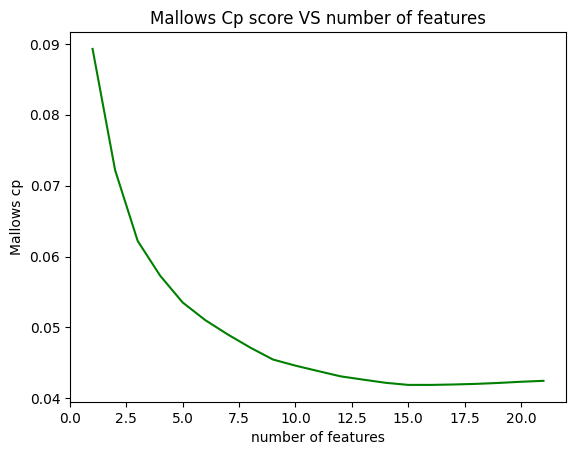

Number of selected features by forward selection: 16
Best features by forward selection: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]


In [33]:
best_features_list = forward_selection(X_train_normalize, y_train)
print(f'Number of selected features by forward selection: {len(best_features_list)}')
print(f'Best features by forward selection: {best_features_list}')

In [34]:
print(f"The features that remain in our analysis after the forward selection process: \
    {list(train_data_features[best_features_list])}")

The features that remain in our analysis after the forward selection process:     ['area', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished', 'bedrooms_2.0', 'bedrooms_6.0', 'bathrooms_2.0', 'stories_2', 'stories_3', 'stories_4', 'parking_1']


Extracting the remain features from the forward selection and keep them in our train and test datasets:

In [35]:
X_forward_reduced_train = X_train_normalize[:, best_features_list]
X_train_before_split = X_forward_reduced_train
y_train_before_split = y_train.copy()
train_data_reduction = train_data.iloc[:, best_features_list]
X_Test = X_test_normalize[:, best_features_list]

## Modeling & Model evaluation

Our ML modules will be Random Forrest, Multiple Linear Regression and Multilayer Perceptron. 

In this part we'll run our modules, and if possible, try to understand the importance of every feature in our data to the log pricing prediction.

We will be running them over the train dataset and try to improve them as much as possible, as well as evaluating them with K-fold cross validation process as well as checking their performance using MSE score for every module.

We will also try to explain if our algorithm is overfitted, and if so, how can we solve (at least partially) this problem.

In this part, we'll chose our module for the test dataset prediction, based on which one of them preformed the best MSE score (lowest MSE).

Split the data to train and validation in order to test the success of our models:

In [36]:
X_Train, X_val, y_Train, y_val = train_test_split(X_train_before_split, y_train_before_split, \
    test_size = 0.2, random_state= 42, shuffle=True)

### Random Forest

Random Forests overcome the problem of correlative features by considering random subsets of splits at every splitting decision. Different data sets are generated via bootstrap. Each DT is created for a different dataset, where each split 
considers a subset of the features. We will implement Random Forest using GridSearchCV. GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model of Random Forest as well as the parameters that we will give will be entered into the GridSearchCV method. After extracting the best parameters values, Random Forest Model will be implement by using them.

![https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

In [37]:
parameters = {'n_estimators':[180, 190, 200], 'criterion':['squared_error', 'absolute_error'],\
     'max_depth': [70, 80, 90], 'min_samples_leaf':[1,2], 'min_samples_split':[3,5]}
KF = KFold(n_splits = 5, shuffle = True, random_state=42)
model_rf = RandomForestRegressor(random_state = 0)
grid_search_rf = GridSearchCV(model_rf, parameters, cv = KF, scoring = 'neg_mean_squared_error')
grid_search_rf.fit(X_Train, y_Train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [70, 80, 90], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 5],
                         'n_estimators': [180, 190, 200]},
             scoring='neg_mean_squared_error')

In [38]:
best_params_rf = grid_search_rf.best_params_
y_pred_log_prices = grid_search_rf.predict(X_Train)
MSE_RF = mean_squared_error(y_Train, y_pred_log_prices)
print(f'Best Parameters: {best_params_rf} \n')
print(f'Train Mean Squared Error score for best parameters: {MSE_RF}')

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} 

Train Mean Squared Error score for best parameters: 0.012953101451806169


Feature importance:

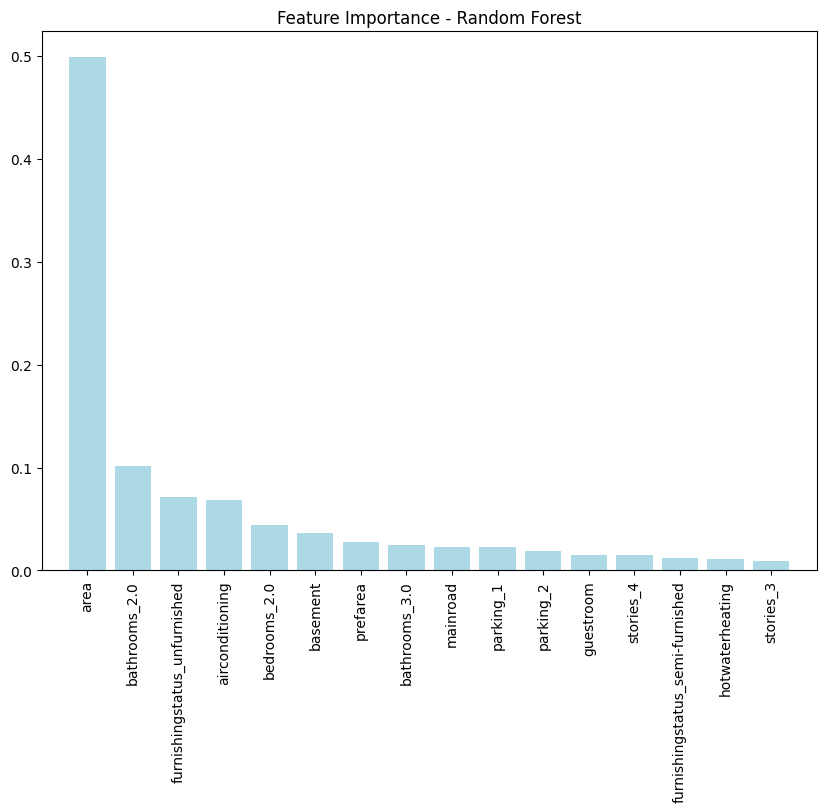

Feature Ranking:
1. area (49.89%)
2. bathrooms_2.0 (10.15%)
3. furnishingstatus_unfurnished (7.14%)
4. airconditioning (6.80%)
5. bedrooms_2.0 (4.45%)
6. basement (3.66%)
7. prefarea (2.74%)
8. bathrooms_3.0 (2.42%)
9. mainroad (2.32%)
10. parking_1 (2.29%)
11. parking_2 (1.93%)
12. guestroom (1.50%)
13. stories_4 (1.49%)
14. furnishingstatus_semi-furnished (1.22%)
15. hotwaterheating (1.06%)
16. stories_3 (0.94%)


In [39]:
R_F_model = model_rf.fit(X_Train, y_Train)
importances = R_F_model.feature_importances_
desc_indices = np.argsort(importances)[::-1]
names = []
for i in desc_indices:
    names.append(train_data_reduction.columns[i])

plt.figure(figsize=(10,7))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X_Train.shape[1]), importances[desc_indices], color='lightblue', align='center')
plt.xticks(range(X_Train.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_Train.shape[1]])
plt.show()

# Print the feature ranking
print("Feature Ranking:")
for i, feature in enumerate(train_data_reduction.columns[desc_indices]):
    print(("{}. {} ({:.2f}%)").format(i+1, feature, importances[desc_indices][i]*100))

Feature importance conclusions:

 - We can see that we have one main feature that contibutes the most to our Random Forest Model. Our intuition to why this feature most important is because it's makes sense that the size (area) of the house will have high influence on it's price.

Visualization of the Random Forest Regressor Model:

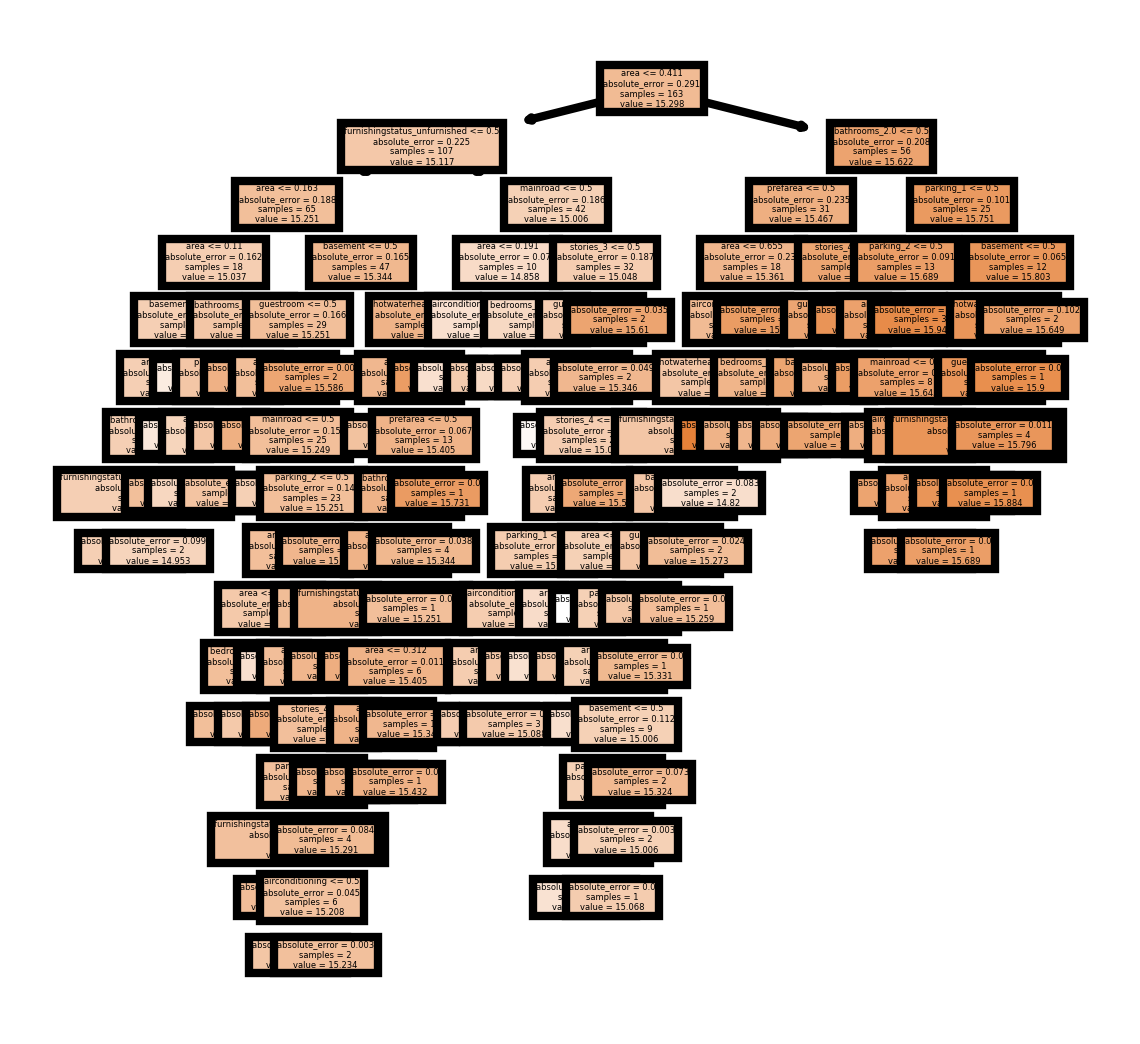

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, y_Train, random_state=0)
rf = RandomForestRegressor(**best_params_rf).fit(X_train, Y_train)               
fn=train_data_reduction.columns
cn='log_price'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=600)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);

Conclutions:
 - By the Tree plot we can see that Random forest works on several decision trees. Plotting them gives a hunch basically how a model predicts the value of a target variable by learning simple decision rules inferred from the data features.
 - Every decision at a node is made by classification using a single feature from our train data.

### Multiple Linear Regression

Multiple linear regression (MLR), is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response (dependent) variables.

![https://keepingupwithdatascience.files.wordpress.com/2022/01/linearregression-1.png?w=1200](https://keepingupwithdatascience.files.wordpress.com/2022/01/linearregression-1.png?w=1200)

In [41]:
model_lr = LinearRegression().fit(X_Train, y_Train)
y_pred_log_prices = model_lr.predict(X_Train)
MSE_LR = mean_squared_error(y_Train, y_pred_log_prices)
print(f'Train mean squared error score: {MSE_LR}')

Train mean squared error score: 0.03563530237397644


Feature importance:

Feature: 0, Score: 0.44281
Feature: 1, Score: 0.12484
Feature: 2, Score: 0.07382
Feature: 3, Score: 0.08213
Feature: 4, Score: 0.14794
Feature: 5, Score: 0.18422
Feature: 6, Score: 0.08852
Feature: 7, Score: 0.04266
Feature: 8, Score: -0.07803
Feature: 9, Score: -0.11622
Feature: 10, Score: 0.14411
Feature: 11, Score: 0.29201
Feature: 12, Score: 0.12668
Feature: 13, Score: 0.22892
Feature: 14, Score: 0.09692
Feature: 15, Score: 0.09014


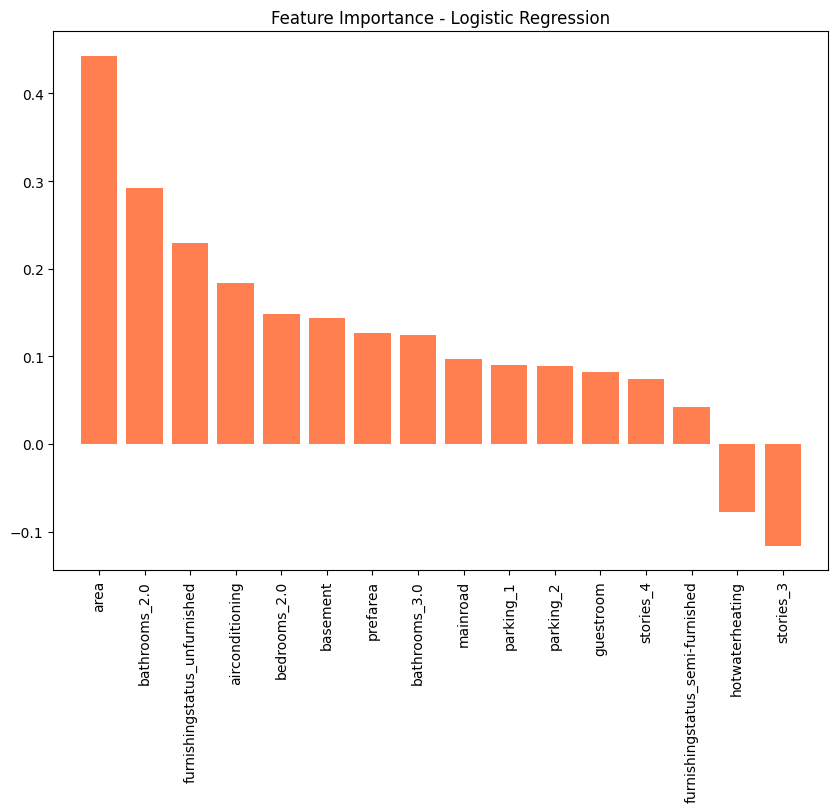

In [42]:
importances = model_lr.coef_
desc_indices = np.argsort(importances)[::-1]
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(10,7))
plt.title("Feature Importance - Logistic Regression")
plt.bar(range(X_Train.shape[1]), importances[desc_indices], color='coral', align='center')
plt.xticks(range(X_Train.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_Train.shape[1]])
plt.show()

Feature importance conclusions:

 - We can see that also in Linear Regression Model we have one main feature that contibutes the most to our Model. Our intuition to why this feature most important is because it is make sense that the size (area) of the house will have high influence to it's price.
 - There are also two features that have negetive influence on our Model. It may suggest that they have, for some reason, a negative impact on the price of the house.


### Multilayer Perceptron

Multilayer Perceptron is a neural network where the mapping between inputs and output is non-linear.
A Multilayer Perceptron has input and output layers, and one or more hidden layers with many neurons stacked together. And while in the Perceptron the neuron must have an activation function that imposes a threshold, like ReLU or sigmoid, neurons in a Multilayer Perceptron can use any arbitrary activation function. We will implement Multilayer Perceptron using also GridSearchCV as we did in the Random Forest Model.

![https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp](https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp)

In [43]:
parameters = {'hidden_layer_sizes':[20, 50, 100], 'activation':['identity', 'logistic', 'tanh', 'relu']\
    , 'solver':['Ibfgs', 'sgd', 'adam']}
KF = KFold(n_splits = 5, shuffle = True, random_state=42)
model_ml = MLPRegressor(random_state = 0)
grid_search_ml = GridSearchCV(model_ml, parameters, cv = KF, scoring = 'neg_mean_squared_error')
grid_search_ml.fit(X_Train, y_Train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(random_state=0),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [20, 50, 100],
                         'solver': ['Ibfgs', 'sgd', 'adam']},
             scoring='neg_mean_squared_error')

In [44]:
best_params_ml = grid_search_ml.best_params_
y_pred_log_prices = grid_search_ml.predict(X_Train)
MSE_MLP = mean_squared_error(y_Train, y_pred_log_prices)
print(f'Best Parameters: {best_params_ml} \n')
print(f'Train mean squared error score for best parameters: {MSE_MLP}')

Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': 100, 'solver': 'sgd'} 

Train mean squared error score for best parameters: 0.06410544767818227


### Choosing the best Model - <br>

In [45]:
def Choose_Best_Model(MSE_S):
    return np.min(MSE_S), np.argmin(MSE_S)

MSE_S_MODELS = ['Random Forest', 'Linear Regression', 'Multilayer Perceptron']
MSE_S = np.array([MSE_RF, MSE_LR, MSE_MLP])
MSE_Best_Score, MSE_MODEL_index = Choose_Best_Model(MSE_S)
print(f"The best model that we will use is: {MSE_S_MODELS[MSE_MODEL_index]}, and it's MSE is: {MSE_Best_Score}")

The best model that we will use is: Random Forest, and it's MSE is: 0.012953101451806169


Based on the Train MSE of every model, we can see that the Train MSE of Random Forest Model is the lowest between all MSE's of different models. Therefore, we will choose this model to best represent our results and predict the price percentage increase of the test data.

## Making a Prediction

In this part we'll make our predictions on the test dataset we've created using the model who preformed the best out of all models we ran in earlier stages of the project - Random Forest.

After the testing, we will discuss our results (and how good they are) and insights we got from our project with regards to the dataset in hand.

In [46]:
def RandomForestRegressor_Function(best_params, X_Train, y_Train):
    random_state = np.random.RandomState(0)
    model = RandomForestRegressor(**best_params, random_state=random_state)
    model.fit(X_Train, y_Train)
    return model

In [47]:
model = RandomForestRegressor_Function(best_params_rf, X_Train, y_Train)
actual_prices = list(actual_test_log_price['log_price'])
predicted_log_prices = model.predict(X_Test)
predictions_DF = pd.DataFrame(data = predicted_log_prices)
predictions_DF['Actual_Log_Price'] = actual_prices
predictions_DF = predictions_DF.rename(columns = {0:'Predicted_Log_Price'})
predictions_DF.insert(0, 'Observation_id', range(0, X_Test.shape[0]))
predictions_DF.to_csv("Predicted_Log_Housing_prices.csv", index = False)

Plotting the relation between actual log prices and predicted log prices on our test data:

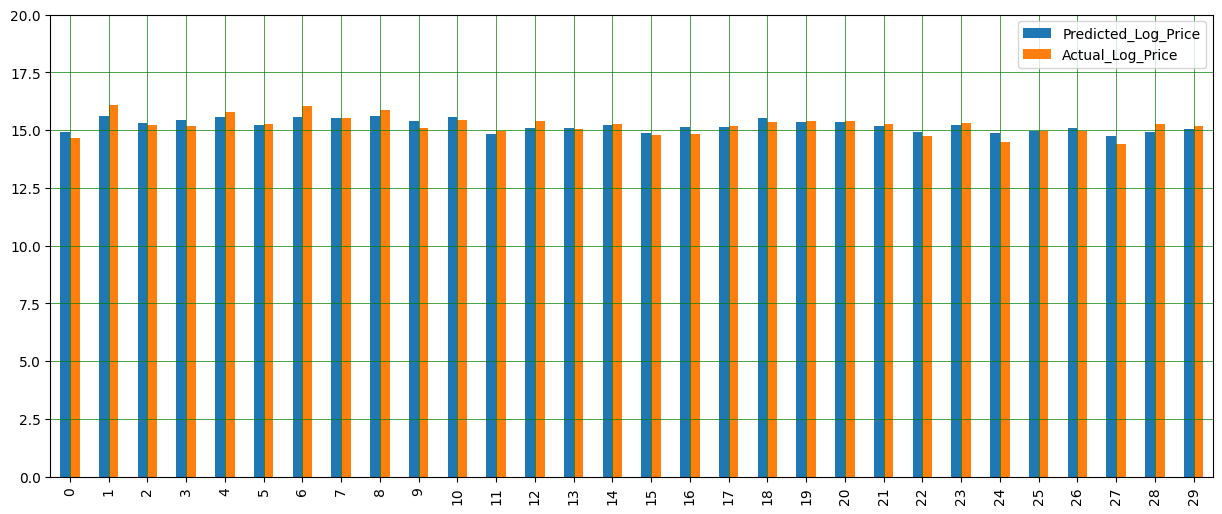

In [48]:
DF = predictions_DF.drop('Observation_id', axis = 1)
DF = DF.head(30)
DF.plot(kind='bar',figsize=(15,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylim(0,20)
plt.show()

In [49]:
from sklearn.linear_model import LinearRegression
X = np.array(predicted_log_prices)
y = np.array(actual_test_log_price)
Linear_R = LinearRegression().fit(X.reshape((-1,1)), y.reshape((-1,1)))
y_pred = np.array([Linear_R.intercept_[0] + Linear_R.coef_[0] * i for i in range(0,109)])

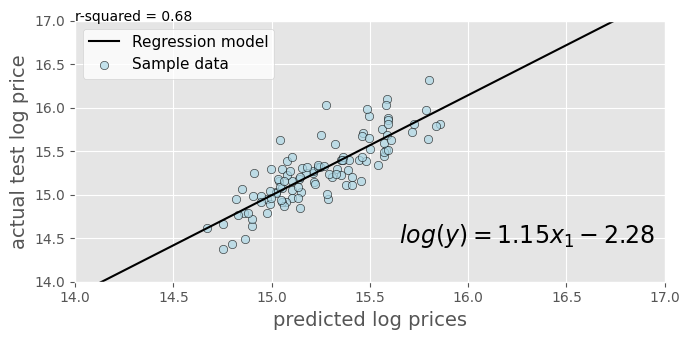

In [50]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', c='lightblue', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('actual test log price', fontsize=14)
ax.set_xlabel('predicted log prices', fontsize=14)
ax.set_xlim(14,17)
ax.set_ylim(14,17)
ax.legend(facecolor='white', fontsize=11)
ax.text(0.55, 0.15, '$log(y) = %.2f x_1 - %.2f $' % (Linear_R.coef_[0], abs(Linear_R.intercept_[0])),\
     fontsize=17, transform=ax.transAxes)
ax.annotate("r-squared = {:.2f}".format(r2_score(y, X)), (14,17))

fig.tight_layout()

This graph shows the close connection and the correlation between our predictions of prices and the actual values found in the test dataset in another way to show the wellness of their connection, and also gives another way to interprate it.

## Recap & Conclusions

As mentioned in the introduction, the main goal of our project was to try and predict housing prices, with as much precession as possible.
Our predictions are based on using simple and complicated ML models on a dataset of households which contain several features with regards to each observation, such as the area (size) of the house, number of parking spots, furnishing status and so on.

The first stage of our project was Data Exploration. Our purpose was to understand the dataset better (mainly the features that were the most relevant to us for later stages of the project). 
In that part we've shown how the dataset looks like (distributions of some features) and some key visualization because we believe that a picture is worth a thousand words (and a good visualization can be worth even more). 

The second stage was all about Data Pre-Processing. The idea here was to prepare our dataset in such a way that the ML models we chose can preform on it, without losing the meaning of any feature. It's also important to mention that we've decided to predict the log of the housing price instead of the actual price, so we can see how a change in quantities of different features affect the housing price by percentages.

The third stage was focused on running and evaluating our ML models. We chose to perform Th models Random Forest, Multiple Linear Regression and Multilayer Perceptron. We performed them on the train dataset and evaluating them by the results we got from using the MSE scoring method, which fits very well the type of problem we're trying to solve. The ambition here was to pick the best way we can to predict the log price of the house while seeing how a change in each feature affects it, and trying to make the bias variance tradeoff accurate as possible.

The last stage was making a prediction. Now's the time to finally check out our results! i.e., comparing our predictions to the actual log of prices found in our test dataset. We took our best model and ran it on the test and gathered the results into a different csv file so it would be easier to make comparisons. We also believe that the addition of some more visualizations in this part can help you, the reader, to understand the strong resemblance between our predictions and the real values found in the test dataset.

A lot of effort was put into this project, but it's still not perfect. We think that trying to estimate such a complicated subject such as a price of a house based only on 12 initial features is obviously lacking in depth of analysis, and if we had more features (for example the country which generated the dataset, or the amount of crime that happens near the house) could have helped us make even better and more precise predictions.
Never the less, even though we are not real estate agents nor housing market experts, we do believe that our work can be very beneficial to any investor or potential buyer that has some basic knowledge/information on the house he's interested in.

We had a lot of fun making this project and we hope you'll find it as interesting as we did while working on it.


Contribution of each team member:

The project was mostly done together, but we did our best to divide the project such that each one of us could bring his strength through out the differnet parts. Yarden managed the part of writing the code with the help of Asaf and Gilad. The process of making the conclusions and explanations mannaged mostly by Gilad and Asaf with the help of Yarden.